# UMPIRE

>Simon Robinson, H. Schödl, S. Trattnig  
**A method for unwrapping highly wrapped multi-echo phase images at very high field: UMPIRE**   
 Magnetic Resonance in Medicine. 2014 Jul;72(1):80-92. DOI: [10.1002/mrm.24897](https://onlinelibrary.wiley.com/doi/10.1002/mrm.24897). PMID: 23901001; PMCID: PMC4062430.


**Here we test our implementation of the UMPIRE algorithm by importing and using our custom module**

<a id="0"></a> <br>
## Table of Contents  
1. **[Wrapped Phase Image Generation](#1)**
    1. [Generate Phase Images](#1a)
    2. [Artificially Wrap Phase](#1b)
    
2. **[UMPIRE](#2)**
    1. [STEP 0: Define Echo Times, $\Delta T$ and $\delta t$](#2_1)
    2. [STEP 1: Phase images $\theta_i$ are reconstructed for each echo time $T_{Ei}$](#2_2)
    3. [STEP 2: Phase Difference Images are calculated](#2_3)
    4. [STEP 3: Difference Between Phase Difference Images is calculated](#2_4)
    5. [STEP 5: Identify wraps in PD image using $\omega$](#2_5)
    6. [STEP 6: Unwrapping PD images ( by pixelwise substraction of $2 \pi\cdot n$)](#2_6)
    7. [STEP 7: Obtain higher SNR estimate of $\omega^\ast$ using unwrapped PD images](#2_7)
    8. [STEP 8: Use refined $\omega^\ast$-map to identify wraps in original phase images](#2_8)
    9. [STEP 9: Remove wraps that occured during TE](#2_9)
    10. [STEP 10: Calculate Reciever Phase Offset R](#2_10)
    11. [STEP 11: Substract Reciever Offset from each phase image](#2_11)
    12. [STEP 12: (See step 8) Re-estimate number of wraps that occured between 0 and $T_Ei$](#2_12)
    13. [STEP 13: Finally yield images free of wraps due to both reciever offsetand $\Delta B_0$ variations](#2_13)
    
3. **[Comparison to Original: Reciever Offset is calculated out!](#2_14)**


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from umpire import UMPIRE
from umpire.utils import plot_colorbar, plot_image_series

# custom manual import of test lib
import sys
sys.path.append("../tests")
from test_umpire import generate_simulated_data_2D, wrap_phase

<a id="1"></a>      
# 01. Wrapped Phase Image Generation

<a id="1a"></a> 
### Generate Phase Images

The phase image get a

- static gradient along the y-axis (that is, only spatially dependent) and
- a dynamic gradient along the x-axis (that is, the gradient changes both with echo time TE and location x)

In [2]:
TEs = [5, 10, 16]
img_dims = (128, 128)

In [3]:
phis = generate_simulated_data_2D(img_dims, TEs)

<a id="1b"></a> 
### Artificially Wrap Phase

The measured phase $\theta$ can only be defined over a range spannig 2$\pi$ rad means that vlaues of the true phase $\Phi$ outside this range become aliased:

$$ \theta = \Phi - n2\pi \quad\text{with}\quad n = \Bigg\lfloor\frac{\Phi}{2\pi}\Bigg\rfloor$$

With the brackets denoting the floor function.

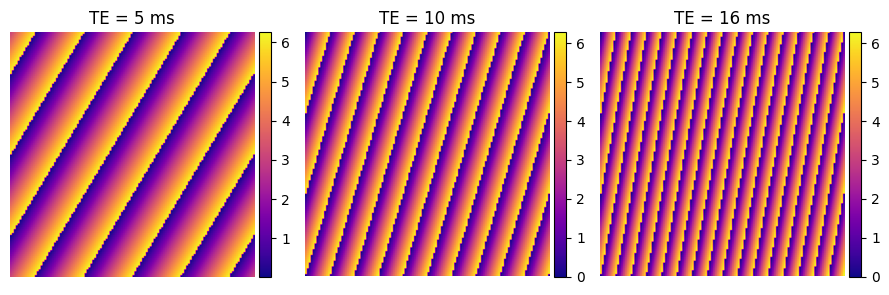

In [4]:
phis_wrapped = wrap_phase(phis)

plot_image_series(phis_wrapped, [f"TE = {t} ms" for t in TEs], figsize=(9,4))

------
<a id="2"></a> <br>
# 02. UMPIRE

<a id="2_1"></a> <br>
#### STEP 1: Phase images $\theta_i$ are reconstructed for each echo time $T_{Ei}$

Note: This step is for complex data, when phase images are provided the arrays stay untouched.

In [5]:
out_1 = UMPIRE(phis_wrapped, TEs, debug_return_step=1)

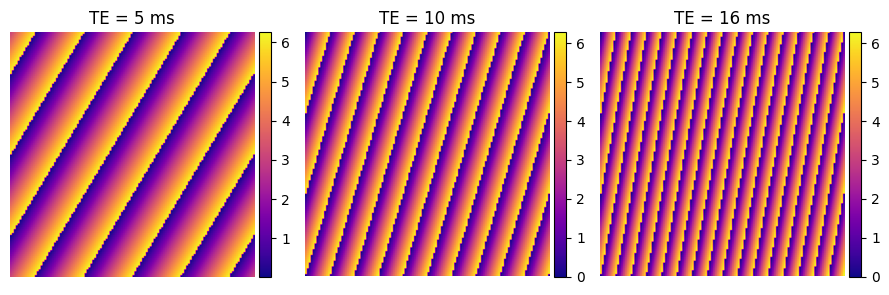

In [6]:
plot_image_series(out_1, [f"TE = {t} ms" for t in TEs], figsize=(9,4))

<a id="2_2"></a> <br>
#### STEP 2: Phase Difference Images are calculated

\begin{equation} 
\theta_{i+1, i} = \angle \exp(i (\theta_{i+1} - \theta_i))
\end{equation}

In [7]:
out_2 = UMPIRE(phis_wrapped, TEs, debug_return_step=2)

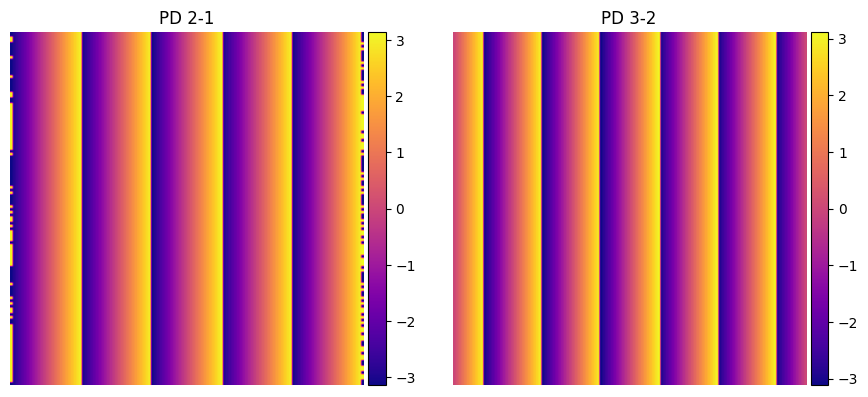

In [8]:
plot_image_series(out_2, [f'PD {i+2}-{i+1}' for i in range(len(TEs)-1)], figsize=(9,4))

<a id="2_3"></a> <br>
#### STEP 3: Difference Between Phase Difference Images is calculated


\begin{equation} 
\theta_{i+2, i+1, i} = \angle \exp(i (\theta_{i+2} - 2\theta_{i+1} + \theta_i))
\end{equation}

In [9]:
out_3 = UMPIRE(phis_wrapped, TEs, debug_return_step=3)

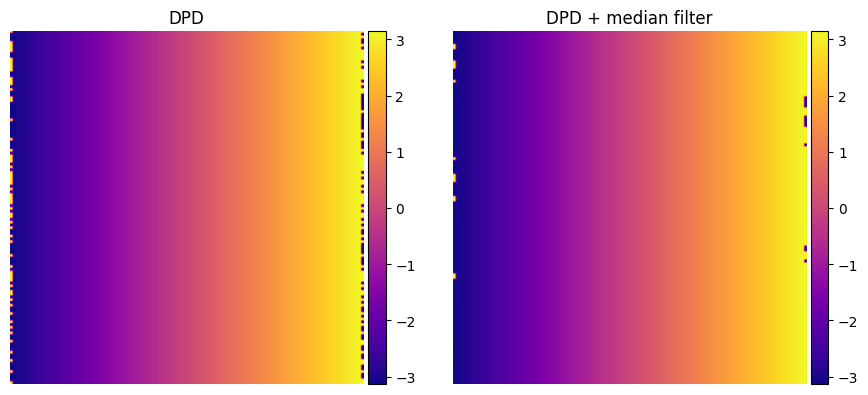

In [10]:
plot_image_series(out_3, ["DPD", "DPD + median filter"], figsize=(9,4))

<a id="2_4"></a> <br>
#### STEP 4: Convert DPD to $\omega$-image

\begin{equation}
\omega = \frac{\theta_{i+2, i+1, i}}{\delta T_E}
\end{equation}

In [11]:
out_4 = UMPIRE(phis_wrapped, TEs, debug_return_step=4)

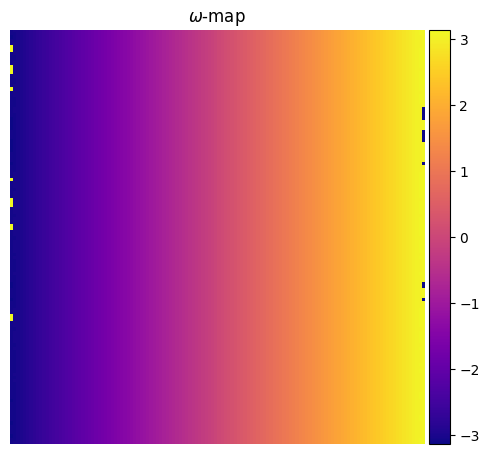

In [12]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))

ax.imshow(out_4, cmap='plasma')
plot_colorbar(fig, ax, out_4)
ax.axis('off')
ax.set_title('$\omega$-map')
    
fig.tight_layout()

<a id="2_5"></a> <br>
#### STEP 5: Identify wraps in PD image using $\omega$

\begin{align}
n_{i+1, i} = \Bigg\lfloor \frac{\theta_{i+1, i} - (T_{Ei+1} - T_{Ei}) \cdot \omega}{2\pi} \Bigg\rfloor
\end{align}

In [13]:
out_5 = UMPIRE(phis_wrapped, TEs, debug_return_step=5)

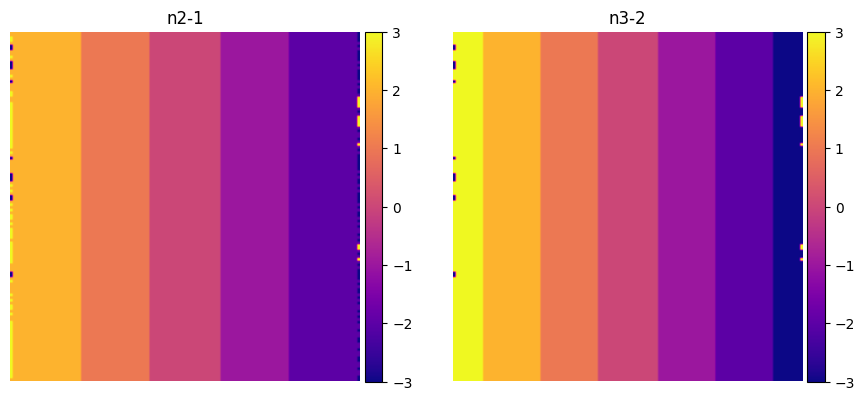

In [14]:
plot_image_series(out_5, [f'n{i+2}-{i+1}' for i in range(len(out_5))], figsize=(9,4))

<a id="2_6"></a> <br>
#### STEP 6:   Unwrapping PD images ( by pixelwise substraction of $2 \pi\cdot n$)

\begin{align}
\theta'_{i+1, i} = \theta_{i+1, i} - 2\pi n_{i+1, i}
\end{align}

In [15]:
out_6 = UMPIRE(phis_wrapped, TEs, debug_return_step=6)

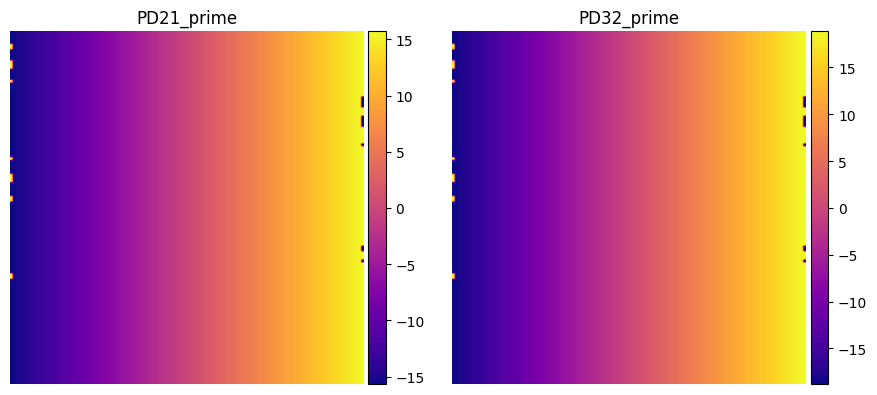

In [16]:
plot_image_series(out_6, [f'PD{i+2}{i+1}_prime' for i in range(len(out_6))], figsize=(9,4))

<a id="2_7"></a> <br>
#### STEP 7: Obtain higher SNR estimate of $\omega^\ast$ using unwrapped PD images

\begin{align}
\omega^\ast = \frac{\theta'_{i+1, i}}{\Delta T_E}
\end{align}

A magnitude-weighted average of $\theta'_{3,2}$ and $\theta'_{2,1}$ could be used here, we use only one PD here.

In [17]:
out_7 = UMPIRE(phis_wrapped, TEs, debug_return_step=7, magnitude_weighted_omega_star=False)

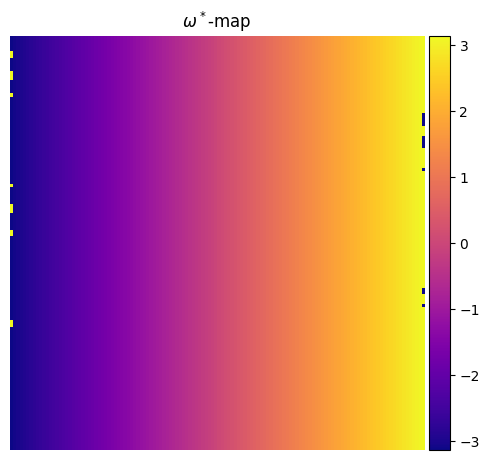

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))

ax.imshow(out_7, cmap='plasma')
plot_colorbar(fig, ax, out_4)
ax.axis('off')
ax.set_title('$\omega^*$-map')
    
fig.tight_layout()

<a id="2_8"></a> <br>
#### STEP 8: Use refined $\omega^\ast$-map to identify wraps in original phase images

\begin{align}
n_i = \Bigg\lfloor \frac{\theta_i - T_{Ei} \cdot \omega^\ast}{2\pi} \Bigg\rfloor
\end{align}

In [19]:
out_8 = UMPIRE(phis_wrapped, TEs, debug_return_step=8)

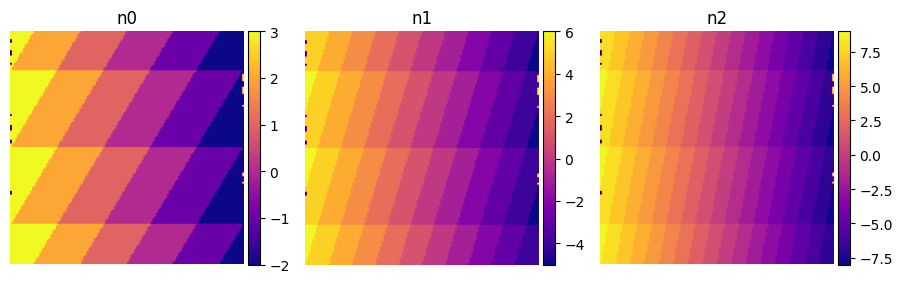

In [20]:
plot_image_series(out_8, [f"n{i}" for i in range(len(out_8))], figsize=(9,4))

<a id="2_9"></a> <br>
#### STEP 9: Remove wraps that occured during TE

\begin{align}
\theta'_i = \theta_i - 2\pi n_i
\end{align}

In [21]:
out_9 = UMPIRE(phis_wrapped, TEs, debug_return_step=9)

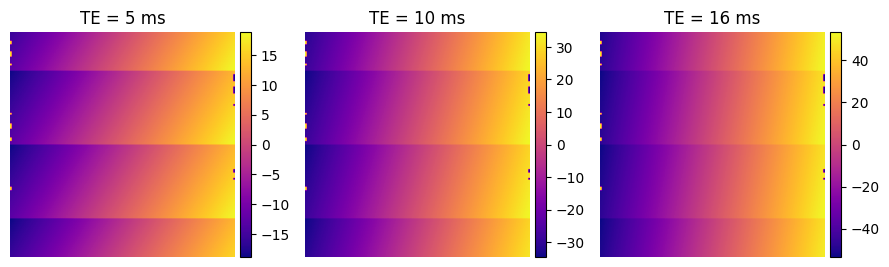

In [22]:
plot_image_series(out_9, [f"TE = {t} ms" for t in TEs], figsize=(9,4))

<a id="2_10"></a> <br>
#### STEP 10: Calculate Reciever Phase Offset R

\begin{align}
R = \frac{T_{E1}\cdot\theta'_2 - T_{E2}\cdot\theta'_1}{T_{E1} - T_{E2}}
\end{align}

In [23]:
out_10 = UMPIRE(phis_wrapped, TEs, debug_return_step=10)

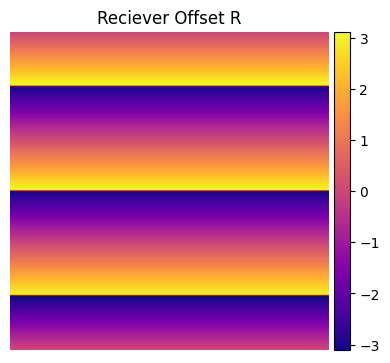

In [24]:
fig, ax = plt.subplots(ncols=1, figsize=(4,4))

ax.imshow(out_10, cmap='plasma')
plot_colorbar(fig, ax, out_10)
ax.axis('off')
ax.set_title('Reciever Offset R')
    
fig.tight_layout()

<a id="2_11"></a> <br>
#### STEP 11: Substract Reciever Offset from each phase image

\begin{align}
\theta_{i0} = \angle\exp(i(\theta_i - R))
\end{align}

In [25]:
out_11 = UMPIRE(phis_wrapped, TEs, debug_return_step=11)

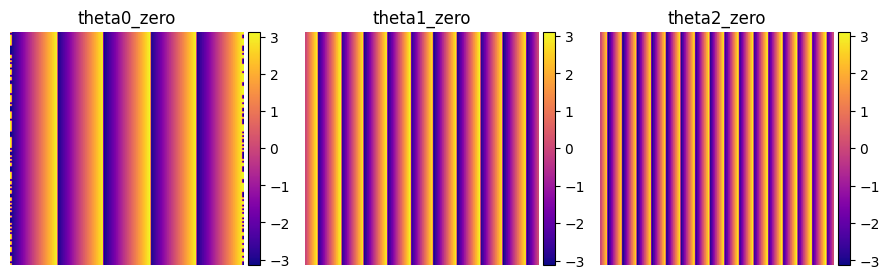

In [26]:
plot_image_series(out_11, [f"theta{i}_zero" for i in range(len(out_11))], figsize=(9,4))

<a id="2_12"></a> <br>
#### STEP 12: (See step 8) Re-estimate number of wraps that occured between 0 and $T_Ei$

\begin{align}
n'_i = \Bigg\lfloor \frac{\theta_{i0} - T_{Ei} \cdot \omega^\ast}{2\pi} \Bigg\rfloor
\end{align}

In [27]:
out_12 = UMPIRE(phis_wrapped, TEs, debug_return_step=12)

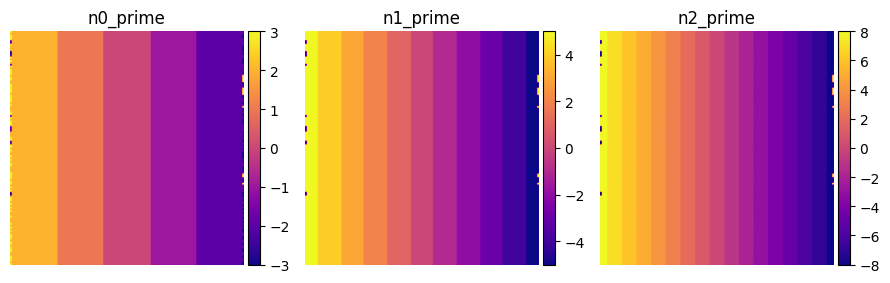

In [28]:
plot_image_series(out_12, [f"n{i}_prime" for i in range(len(out_12))], figsize=(9,4))

<a id="2_13"></a> <br>
#### STEP 13: Finally yield images free of wraps due to both reciever offsetand $\Delta B_0$ variations

\begin{align}
\theta''_i = \theta_{i0} - 2\pi n'_i
\end{align}

In [29]:
out_13 = UMPIRE(phis_wrapped, TEs)

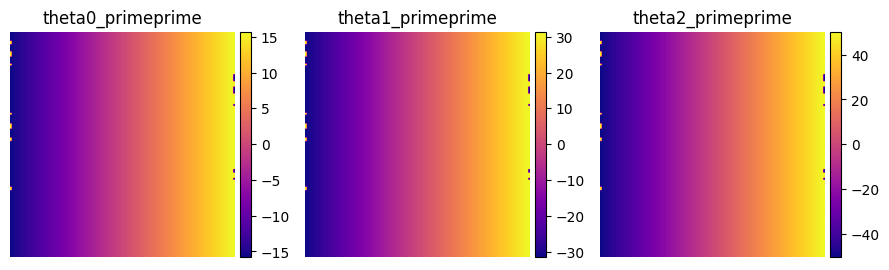

In [30]:
plot_image_series(out_13, [f"theta{i}_primeprime" for i in range(len(out_13))], figsize=(9,4))

# 03. Comparison to Original: Reciever Offset is calculated out!

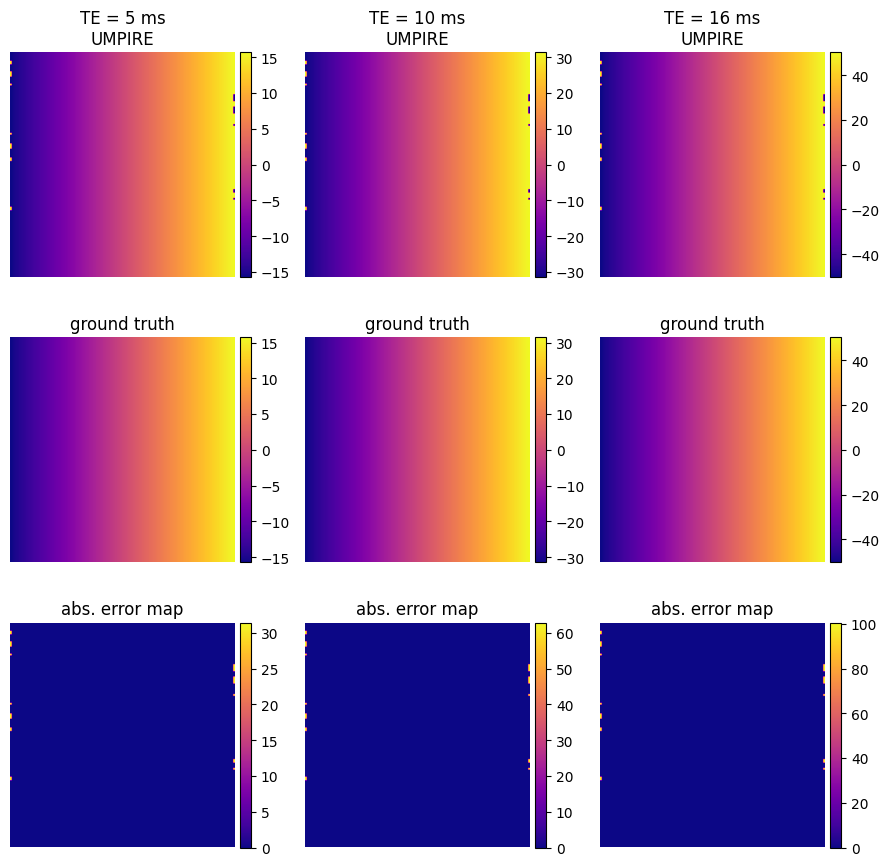

In [31]:
phase_ground_truth = generate_simulated_data_2D(img_dims, TEs, reciever_offset=False)

error = np.abs(out_13 - phase_ground_truth)

plot_image_series(np.concatenate((out_13, phase_ground_truth, error)),
                  [f"TE = {t} ms\nUMPIRE" for t in TEs] + ["ground truth"] * 3 + ["abs. error map"] * 3,
                  nrows=3,
                  figsize=(9,9))